<a href="https://colab.research.google.com/github/joeyuy/Education-Inequality/blob/main/Education_Regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

##### $\rightarrow$ This notebook will run a regression analysis that investigates how a school's socio-economic factors and its capital allocation impacts average ACT/SAT grades. The analysis will use a cleaned data frame that is normalized for regression. The data preparation and details on the data sources can be viewed [here](https://github.com/joeyuy/Education-Inequality/blob/ef0c1e15aa005bc69dbbe63500397fcccabb34cb/Final_Education_Data_Prep.ipynb).


## Import libraries

$\rightarrow$ Import necessary libraries for analysis.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from itertools import combinations

## Load clean data

$\rightarrow$ Load the clean data set from Github.

In [29]:
train = pd.read_csv('https://raw.githubusercontent.com/joeyuy/Education-Inequality/main/education_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/joeyuy/Education-Inequality/main/education_test.csv')

##### $\rightarrow$ Review the contents of the data set.

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5802 entries, 0 to 5801
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5802 non-null   int64  
 1   rate_unemployment  5802 non-null   float64
 2   percent_college    5802 non-null   float64
 3   percent_married    5802 non-null   float64
 4   median_income      5802 non-null   float64
 5   percent_lunch      5802 non-null   float64
 6   year               5802 non-null   object 
 7   state              5802 non-null   object 
 8   zip_code           5802 non-null   int64  
 9   school_type        5802 non-null   object 
 10  school_level       5802 non-null   object 
 11  district_id        5802 non-null   int64  
 12  teacher_salary     5802 non-null   float64
 13  student_support    5802 non-null   float64
 14  staff_support      5802 non-null   float64
 15  admin_salary       5802 non-null   float64
 16  average_act        5802 

In [31]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1451 non-null   int64  
 1   rate_unemployment  1451 non-null   float64
 2   percent_college    1451 non-null   float64
 3   percent_married    1451 non-null   float64
 4   median_income      1451 non-null   float64
 5   percent_lunch      1451 non-null   float64
 6   year               1451 non-null   object 
 7   state              1451 non-null   object 
 8   zip_code           1451 non-null   int64  
 9   school_type        1451 non-null   object 
 10  school_level       1451 non-null   object 
 11  district_id        1451 non-null   int64  
 12  teacher_salary     1451 non-null   float64
 13  student_support    1451 non-null   float64
 14  staff_support      1451 non-null   float64
 15  admin_salary       1451 non-null   float64
 16  average_act        1451 

In [32]:
test.head()

,id,rate_unemployment,percent_college,percent_married,median_income,percent_lunch,year,state,zip_code,school_type,school_level,district_id,teacher_salary,student_support,staff_support,admin_salary,average_act
0,263447007025,-0.499315,0.741734,0.637242,0.791900,-0.879074,2016-2017,MI,48313,Regular School,High,2634470,-0.385745,-1.022994,-0.766360,-1.009519,20.800000
1,484447005075,-0.839361,-0.916893,0.155379,0.137047,-0.015314,2016-2017,TX,77485,Regular School,High,4844470,-0.442477,-0.554748,-1.047423,-0.224725,20.054945
2,482178002199,-1.665876,-0.368779,-0.061277,0.012329,-0.725155,2016-2017,TX,78374,Regular School,High,4821780,-0.118408,-0.244667,0.487881,-0.111661,20.763126
3,482967005548,0.426089,-1.162681,-1.298935,-1.478359,0.546930,2016-2017,TX,78501,Regular School,High,4829670,-0.060899,-0.722916,-0.155049,-0.813320,20.738706
4,530682001002,-0.455451,1.202616,-0.350155,-0.664416,-0.158200,2016-2017,WA,98362,Regular School,High,5306820,0.769092,0.212952,0.294650,-0.730185,22.887668


## State your questions

The overall problem is to determine whether and how average school ACT performance is related to socioeconomic factors. To answer this general problem, you will need to ask specific questions about the data.


##### $\rightarrow$ List your questions about the data that will help you solve the problem.

1. Which socio economic factors regarding a school have the strongest effect on its students' ACT/SAT scores?

2. Where should school funding go to best support ACT/SAT performance?

## Analysis

Perform analyses necessary to answer the questions. You will likely start by trying many things, some of which are useful and some of which are not. Don't be afraid to try different analyses at first. You will edit your notebook to a clean version that retains only the essential components at the end of the project.

This file should clearly produce the graphs, tables, models, etc that appear in the communication assignment.

### Feature Selection

$\rightarrow$ Investigating which subset of features will be most effective in creating a regression model with minimal error.

First create a list of quantitative features:

In [6]:
q_feats = ['rate_unemployment','percent_college','percent_married','median_income','percent_lunch',
           'teacher_salary','student_support','staff_support','admin_salary']

In [7]:
X_train = train[q_feats]
y_train = train['average_act']

X_test = test[q_feats]
y_test = test['average_act']

In [8]:
def best_subset_selection(X, y):
    """ This function returns AIC, BIC, and adjusted R-squared values for use in best subset selection.

    Inputs
    ------
    X : array-like, shape (n_samples, n_features)
        Predictor values

    y : array-like, shape (n_samples, )
        Target values

    Returns
    ------
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    variable_names = X.columns.values

    number_variables = len(variable_names)

    # Initialize empty arrays to hold the AIC, BIC, and adjusted r-squared for the best model
    # at each number of predictors
    best_aic = np.zeros(number_variables)
    best_bic = np.zeros(number_variables)
    best_adjusted_rsquared = np.zeros(number_variables)

    # Initialize empty list to hold the names of the best predictors at each number of predictors
    best_predictors = list()

    # Loop over possible numbers of predictors
    for k in range(number_variables):

        # Get the names of all combinations of k+1 predictors
        subset_names = list(combinations(variable_names, k+1))

        # Loop over all models with k+1 predictors
        for n, predictor_names in enumerate(subset_names):

            # Fit the model
            predictors_subset = X.loc[:, predictor_names]

            model = sm.OLS(y, sm.add_constant(predictors_subset)).fit()

            # Initialize the best values with the first model
            if n == 0:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

            # If a model has a better r-squared, update the best values
            elif model.rsquared > best_rsquared_k:

                best_rsquared_k = model.rsquared
                best_aic_k = model.aic
                best_bic_k = model.bic
                best_adjusted_rsquared_k = model.rsquared_adj
                best_predictors_k = predictor_names

        # Record the values for the best model at this number of predictors
        best_bic[k] = best_bic_k
        best_aic[k] = best_aic_k
        best_adjusted_rsquared[k] = best_adjusted_rsquared_k
        best_predictors.append(best_predictors_k)

    return best_aic, best_bic, best_adjusted_rsquared, best_predictors

In [9]:
def plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors):
    """ Plot the best AIC, BIC, and adjusted R-squared values at each number of possible predictors

    Input
    -----
    best_aic : AIC for the best model at each number of possible predictors

    best_bic : BIC for the best model at each number of possible predictors

    best_adjusted_rsquared : adjusted R-squared for the best model at each number of possible predictors

    best_predictors : predictor names for the best model at each number of possible predictors

    """

    number_predictors = np.arange(len(best_aic))+1

    plt.subplots(1,3, figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(number_predictors, best_aic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_aic)], np.min(best_aic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('AIC', fontsize=18)
    #plt.title(best_predictors[np.argmin(best_aic)])

    plt.subplot(1,3,2)
    plt.plot(number_predictors, best_bic, 'b-o')
    plt.plot(number_predictors[np.argmin(best_bic)], np.min(best_bic), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('BIC', fontsize=18)
    #plt.title(best_predictors[np.argmin(best_bic)])

    plt.subplot(1,3,3)
    plt.plot(number_predictors, best_adjusted_rsquared, 'b-o');
    plt.plot(number_predictors[np.argmax(best_adjusted_rsquared)], np.max(best_adjusted_rsquared), 'ro')
    plt.xticks(number_predictors)
    plt.xlabel('Number of predictors', fontsize=18)
    plt.ylabel('Adjusted R-squared', fontsize=18)
    #plt.title(best_predictors[np.argmax(best_adjusted_rsquared)])

    plt.subplots_adjust(wspace = 0.3)

In [10]:
best_aic, best_bic, best_adjusted_rsquared, best_predictors = best_subset_selection(X_train, y_train)

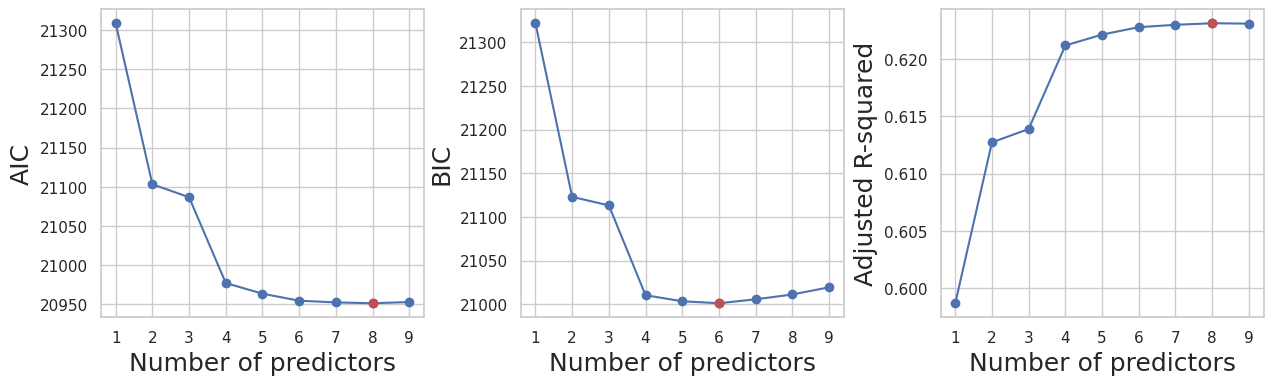

In [11]:
plot_best_subset_results(best_aic, best_bic, best_adjusted_rsquared, best_predictors)

It appears like the best subset of features will be 6, 7, or 8. We want minimized AIC and BIC, with maximized Adjusted R-squared.

In [12]:
best_predictors

[('percent_lunch',),
 ('percent_college', 'percent_lunch'),
 ('rate_unemployment', 'percent_college', 'percent_lunch'),
 ('percent_college', 'percent_lunch', 'teacher_salary', 'student_support'),
 ('rate_unemployment',
  'percent_college',
  'percent_lunch',
  'teacher_salary',
  'student_support'),
 ('rate_unemployment',
  'percent_college',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support'),
 ('rate_unemployment',
  'percent_college',
  'percent_married',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support'),
 ('rate_unemployment',
  'percent_college',
  'percent_married',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support',
  'admin_salary'),
 ('rate_unemployment',
  'percent_college',
  'percent_married',
  'median_income',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support',
  'admin_salary')]

In [13]:
subset_6 = ['rate_unemployment',
  'percent_college',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support']

subset_7 = ['rate_unemployment',
  'percent_college',
  'percent_married',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support']

subset_8 = ['rate_unemployment',
  'percent_college',
  'percent_married',
  'percent_lunch',
  'teacher_salary',
  'student_support',
  'staff_support',
  'admin_salary']

In [14]:
X_train_6 = X_train[subset_6]
X_test_6 = X_test[subset_6]

X_train_7 = X_train[subset_7]
X_test_7 = X_test[subset_7]

X_train_8 = X_train[subset_8]
X_test_8 = X_test[subset_8]

### Model Selection

$\rightarrow$ Determining if it is best to proceed with a subset of 6, 7, or 8 features, and with what corresponding tuning parameter?

First define a function to find an effective tuning parameter alpha and its corresponding regression (elastic net) model and mean squared error.

In [15]:
# Create 100 different ridge regression models with randomly selected alpha values.
# Returns a tuple of (best_ridge_model, best_mse, best_alpha)
def rand_find_good_alpha(X_train, y_train):
  best_alpha = None
  best_reg_model = None
  best_mse = None
  for a in np.random.choice(np.linspace(.01,1,10000),1000):
    en_reg = ElasticNet(alpha=a)
    en_reg.fit(X_train, y_train)
    y_pred = en_reg.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    if best_mse is None or mse < best_mse:
      best_mse = mse
      best_reg_model = en_reg
      best_alpha = a
  return (best_alpha, best_reg_model, best_mse)

Test subset of 6 features first

In [16]:
best_alpha_6, best_model_6, best_mse_6 = rand_find_good_alpha(X_train_6, y_train)

In [17]:
print('alpha: ', best_alpha_6)
print('mean sq error: ', best_mse_6)

alpha:  0.010693069306930694
mean sq error:  2.16332515259615


Now test on subset of 7 features

In [18]:
best_alpha_7, best_model_7, best_mse_7 = rand_find_good_alpha(X_train_7, y_train)

In [19]:
print('alpha: ', best_alpha_7)
print('mean sq error: ', best_mse_7)

alpha:  0.011089108910891089
mean sq error:  2.1621094940249797


And finally on 8 features

In [20]:
best_alpha_8, best_model_8, best_mse_8 = rand_find_good_alpha(X_train_8, y_train)

In [21]:
print('alpha: ', best_alpha_8)
print('mean sq error: ', best_mse_8)

alpha:  0.012574257425742575
mean sq error:  2.162064181946852


The model seems to have similar errors for all 3 subsets. In this case, it is best to use the least amount of subsets to save computational power and reduce the likelihood of multi-collinearity.

### Visualizing model results and coefficients

$\rightarrow$ Plotting model performance on train and test data sets and taking note of feature coefficient and intercept values.

In [22]:
a = best_alpha_6
en_reg = ElasticNet(alpha = a).fit(X_train_6, y_train)

In [23]:
y_pred_test = en_reg.predict(X_test_6)
y_pred_train = en_reg.predict(X_train_6)

In [24]:
def plot_model_results(y_train, y_test, y_pred_train, y_pred_test):
  one_train = np.linspace(y_train.min(), y_train.max(), 100)
  one_test = np.linspace(y_test.min(), y_test.max(), 100)
  rmse_test = np.sqrt(np.mean((y_pred_test - y_test)**2))
  rmse_train = np.sqrt(np.mean((y_pred_train - y_train)**2))

  fig,(ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(y_pred_train, y_train, 'o')
  ax1.plot(one_train, one_train, '-', label=f"RMSE = {rmse_train:.2f} points")
  ax1.set_title("Training Set")
  ax1.set_xlabel("Predicted ACT Score")
  ax1.set_ylabel("Actual ACT Score")
  ax1.legend()

  ax2.plot(y_pred_test, y_test, 'o')
  ax2.plot(one_test, one_test, '-', label=f"RMSE = {rmse_test:.2f} points")
  ax2.legend()
  ax2.set_title("Test Set")
  ax2.set_xlabel("Predicted ACT Score")
  ax2.set_ylabel("Actual ACT Score")
  fig.set_size_inches(12, 5)

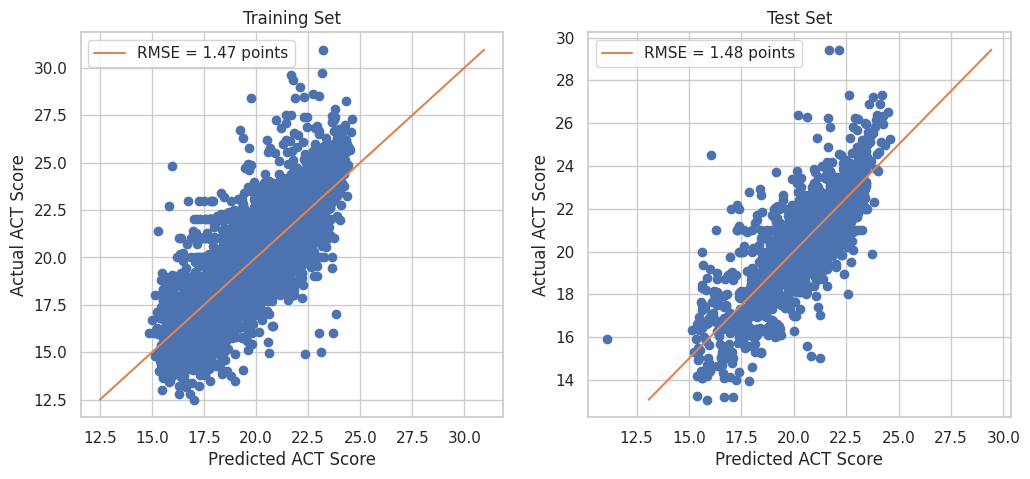

In [25]:
plot_model_results(y_train, y_test, y_pred_train, y_pred_test)

In [26]:
print(en_reg.coef_)
print(en_reg.intercept_)

[-0.09309237  0.27078594 -1.62753458  0.3007152  -0.31638631  0.06343323]
20.397941045233843


In [27]:
for feature_name, coeff in zip(X_train_6.columns, en_reg.coef_.squeeze()):
  print(f"{feature_name}: {coeff:.4f}")

print(f"intercept: {en_reg.intercept_}")

rate_unemployment: -0.0931
percent_college: 0.2708
percent_lunch: -1.6275
teacher_salary: 0.3007
student_support: -0.3164
staff_support: 0.0634
intercept: 20.397941045233843


## Conclusion

With a model that can reliably predict ACT results within 1.5 points, it seems like the socio economic factor with the heaviest influence on ACT scores is the proportion of students in a school that avail of free/reduced price school lunch. There is a negative relationship between this proportion and average ACT scores, and this can be explained by the tendency for higher income class students to attend prestigious schools with expensive cafeterias.

Beyond that, a school in an area with more college degree holders tends to have higher ACT scores as well. A school in such an area likely has many students from families with higher education backgrounds. These families probably expect their children to attend college too and consequently invest in standardized test preparation, which explains the positive relationship.

Lastly, there is a weak negative relationship between ACT scores and a school area's unemployment rate. Residents in places with higher unemployment rates tend to struggle more with pursuing higher education and standardized test taking as whole. The model likely does not weigh this variable too much because chances are that unemployed residents are not prioritizing sending their children to school, which minimizes the impact of unemployment rate on actual recorded ACT scores.

As for how the distribution of invested capital into a school's resources influences ACT scores, there is a positive relationship with teacher salaries and staff support, but a negative realtionship with student support. The positive relationships reflect the importance of making sure instructors are paid well and supported for students to perform well in tests. Interestingly, it seems like the opportunity cost of putting money into student support outweighs its benefits. This is proabably because schools would have to spend much more on student support because of a typically much larger student population compared to faculty and staff, and students would have less initiative to make use of those resources. As such, bigger impacts on education quality can be made by investing capital in other departments like teacher salaries.